This notebook prepares SEM image for models by trimming the banner, rescaling to a desired scale_factor. These images are then (v)stacked and put into a .npy file for quick loading in future model training.

The current tile shape is <b>(128px x 128px)</b>. [24/07/2024]

# Moving images into single directory

In [1]:
# install dependencies

import os
import shutil
import glob
import cv2
from PIL import Image

from matplotlib import pyplot as plt
import numpy as np
from pandas import DataFrame
# view all the metadata stored in the ZEISS TIFF file
# from https://github.com/ks00x/zeiss_tiff_meta.git
from ZeissTiffMD import zeisstiffmeta as zm

In [2]:
# Path setup.
path = 'all_images'

# ZeissMetaData // data processing

In [3]:
# Create the Index for the Pandas DataFrame

df_index = []
for i in range(len(os.listdir(path))):
    df_index.append(os.listdir(path)[i][:-4])
# df_index
# , len(df_index)

top_tab = [zm.zeiss_meta(path+'/'+os.listdir(path)[i]) for i in range(len(os.listdir(path)))]

top_vu = [(x2,x3) for i in range(len(top_tab)) for x0,x1,x2,x3 in top_tab[i] if x1 == 'Pixel Size']
# dict removes duplicates, want to keep all values by making list

top_value = [top_vu[i][0] for i in range(len(top_vu))]
top_unit = [top_vu[i][1] for i in range(len(top_vu))]

In [4]:
import json
import copy
from ZeissTiffMD.metadataSchemaReader import MetadataSchemaReader
from ZeissTiffMD.attributeMapping import AttributeMapping
import datetime as dt
from dateutil import parser
import logging


In [5]:
# create a Pandas DataFrame with index = fileName, and information being the pixel size value and units
df = DataFrame(index = df_index)
df['pixel_size'], df['pixel_size_unit'] = top_value, top_unit

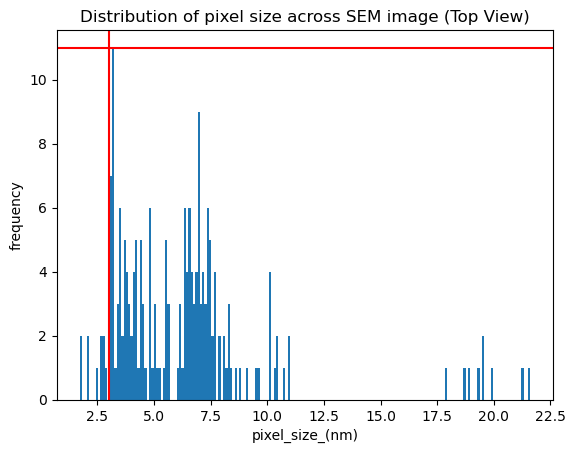

In [6]:
# from matplotlib import pyplot as plt

axarr = df.hist(bins=195)

for ax in axarr.flatten():
    ax.set_xlabel('pixel_size_(nm)')
    ax.set_ylabel('frequency')
    ax.set_title('Distribution of pixel size across SEM image (Top View)')
    ax.grid(False)

    ax.axhline(y=11, color = 'red')
    ax.axvline(x=int(df['pixel_size'].mode()), color = 'red')#,alpha=0.4)

# Image Data Preparation

In [7]:
# Augments images with ZOOM to a target pixel size and banner is CROPped
def imaug(img_path, target_ps):
    
    #PIL image opens image and converts to 3 channel, grayscale, then converted to np.array
    im = Image.open(img_path).convert('RGB')
    na = np.asarray(im)
    
    #finds where the banner is and crops
    white_pixels = np.all(na == 0, axis=2)
    half_white_row = np.where(white_pixels.sum(axis=1) > white_pixels.shape[1] / 2)[0][0]    
    
    #finds the pixel size from metadata, creates a zoom factor, then applied
    im_tab = zm.zeiss_meta(img_path)
    im_ps = [x2 for (x0, x1, x2, x3) in im_tab if x1 == 'Pixel Size']
#     zoom = target_ps / im_ps[0] <-- Original zoom function
    zoom = im_ps[0] / target_ps
    
    im_zoom = cv2.resize(na[:half_white_row - 1], None,
                         fx = zoom,fy = zoom,
                         interpolation = cv2.INTER_CUBIC)    
    
    return im_zoom

In [8]:
# Prepares windows of dimensions (MxN) and places array
def data_prep(im_array, M, N):
    '''
    Input:
        im_array => image_array
        M, N     => dimensions of tile
    Output:
        tilestack  => a stack of images
    '''
    
    tile_shape = (M, N, 3) # images have 3 channels due to PIL Image.convert, to make all images the same
    tiles = [im_array[x:x+M,y:y+N] for x in range(0,im_array.shape[0],M) for y in range(0,im_array.shape[1],N)]
    tiles = [tile for tile in tiles if tile.shape == tile_shape]
    return tiles


In [9]:
# Resizing and rescaling images


sf= 3.225 # the mode of datasets pixel size

all_im = [imaug(os.path.join(path+'/'+ os.listdir(path)[i]), sf) for i in range(len(os.listdir(path)))]


# Collecting stats of image heights*widths after image preprocessing

index = range(len(all_im))
height = []
width= []

for im in range(len(all_im)):
    h = all_im[im][...,0].shape[0]
    w = all_im[im][...,0].shape[1]
    
    height.append(h)
    width.append(w)
    
# Information about the adjusted image dimensions to sf

hw_df = DataFrame(data=[height,width]).T
hw_df = hw_df.rename(columns={0:'height',1:'width'})

hw_df.min(), hw_df.max()

(height    383
 width     545
 dtype: int64,
 height    4599
 width     6865
 dtype: int64)

In [10]:
# Sectioning micrographs

M = 128
N = M

all_tilestack = [data_prep(all_im[i], M, N) for i in range(len(os.listdir(path)))]
# all_tilestacked = np.vstack(all_tilestack)
all_tilestacked = np.vstack(all_tilestack).astype('float32') / 255 # normalize the data to be between 0-1
all_tilestacked = all_tilestacked.mean(axis= -1) # converts to grayscale

np.save('tiles.npy', np.array(all_tilestacked), allow_pickle= True)

print('Total number of images: ',len(all_im))
print('Total number of tiles collected: ', all_tilestacked.shape[0])
print('Shape of one tile: ', all_tilestacked[0].shape)

Total number of images:  195
Total number of tiles collected:  40400
Shape of one tile:  (128, 128)


In [11]:
# Load data; normalised to be between 0 and 1 already

imstack = np.load('tiles.npy', allow_pickle=True)

In [12]:
# Reshape

image_height = imstack.shape[1]
image_width = imstack.shape[2]

imstack = imstack.reshape(imstack.shape[0], image_height, image_width) 

print(f'New Imstack shape = {imstack.shape}')

New Imstack shape = (40400, 128, 128)


In [13]:
# Train-Test-Val split of image data

from sklearn.model_selection import train_test_split
# Train - Test split (80:20)
imstack_train, imstack_test = train_test_split(
    imstack, test_size=0.2, shuffle=True, random_state=0)

# Test - Validate split (50:50)
imstack_test, imstack_val = train_test_split(
    imstack_test, test_size= 0.5, shuffle=True, random_state=0
)

print(f'Train set= {imstack_train.shape}')
print(f'Validation set= {imstack_val.shape}')
print(f'Test set= {imstack_test.shape}')

Train set= (32320, 128, 128)
Validation set= (4040, 128, 128)
Test set= (4040, 128, 128)


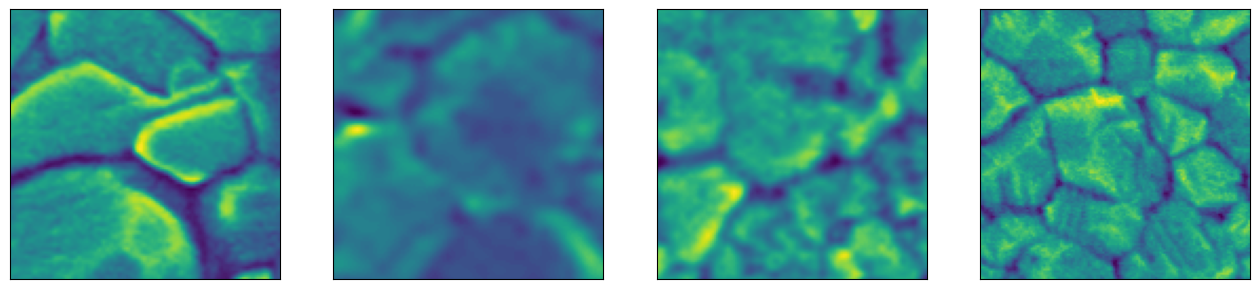

In [14]:
from tensorflow import squeeze
n = np.random.randint(0, len(imstack)-1, 4)

plt.figure(figsize=(16, 6))
for i in range(len(n)):
    # display original
    ax = plt.subplot(1, len(n), i + 1)
#     plt.title("original")
    plt.imshow(squeeze(imstack_train[i]))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()